In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [25]:
# For VS Code import
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mahmoudelhemaly/students-grading-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/philip/.cache/kagglehub/datasets/mahmoudelhemaly/students-grading-dataset/versions/2


In [26]:
# Additional Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use('seaborn-darkgrid')
sns.set(style="darkgrid")


In [27]:
# Load the dataset
df = pd.read_csv(path + "/Students_Grading_Dataset.csv")
df.head()

,Student_ID,First_Name,Last_Name,Email,Gender,Age,Department,Attendance (%),Midterm_Score,Final_Score,...,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,S1000,Omar,Williams,student0@university.com,Female,22,Engineering,52.29,55.03,57.82,...,85.90,56.09,F,6.2,No,Yes,High School,Medium,5,4.7
1,S1001,Maria,Brown,student1@university.com,Male,18,Engineering,97.27,97.23,45.80,...,55.65,50.64,A,19.0,No,Yes,NaN,Medium,4,9.0
2,S1002,Ahmed,Jones,student2@university.com,Male,24,Business,57.19,67.05,93.68,...,73.79,70.30,D,20.7,No,Yes,Master's,Low,6,6.2
3,S1003,Omar,Williams,student3@university.com,Female,24,Mathematics,95.15,47.79,80.63,...,92.12,61.63,A,24.8,Yes,Yes,High School,High,3,6.7
4,S1004,John,Smith,student4@university.com,Female,23,CS,54.18,46.59,78.89,...,68.42,66.13,F,15.4,Yes,Yes,High School,High,2,7.1


# Getting to know the data
## Descriptive Statistics

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Student_ID                  5000 non-null   object 
 1   First_Name                  5000 non-null   object 
 2   Last_Name                   5000 non-null   object 
 3   Email                       5000 non-null   object 
 4   Gender                      5000 non-null   object 
 5   Age                         5000 non-null   int64  
 6   Department                  5000 non-null   object 
 7   Attendance (%)              4484 non-null   float64
 8   Midterm_Score               5000 non-null   float64
 9   Final_Score                 5000 non-null   float64
 10  Assignments_Avg             4483 non-null   float64
 11  Quizzes_Avg                 5000 non-null   float64
 12  Participation_Score         5000 non-null   float64
 13  Projects_Score              5000 

We can already see that there are some missing data.  We'll look at that in a minute.  First though we will drop the personally identifying columns.

In [29]:
# drop identifying columns and check for nulls
df.drop(['Student_ID', 'First_Name', 'Last_Name', 'Email'], axis=1, inplace=True)
df.isnull().sum()

Gender                           0
Age                              0
Department                       0
Attendance (%)                 516
Midterm_Score                    0
Final_Score                      0
Assignments_Avg                517
Quizzes_Avg                      0
Participation_Score              0
Projects_Score                   0
Total_Score                      0
Grade                            0
Study_Hours_per_Week             0
Extracurricular_Activities       0
Internet_Access_at_Home          0
Parent_Education_Level        1794
Family_Income_Level              0
Stress_Level (1-10)              0
Sleep_Hours_per_Night            0
dtype: int64

We'll address the missing data in a bit.  For now, we'll just file this information away for later.

In [30]:
df.describe()

,Age,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Total_Score,Study_Hours_per_Week,Stress_Level (1-10),Sleep_Hours_per_Night
count,5000.000000,4484.000000,5000.000000,5000.000000,4483.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,21.048400,75.431409,70.326844,69.640788,74.798673,74.910728,4.980024,74.924860,75.121804,17.658860,5.48080,6.488140
std,1.989786,14.372446,17.213209,17.238744,14.411799,14.504281,2.890136,14.423415,14.399941,7.275864,2.86155,1.452283
min,18.000000,50.010000,40.000000,40.000000,50.000000,50.030000,0.000000,50.010000,50.020000,5.000000,1.00000,4.000000
25%,19.000000,63.265000,55.457500,54.667500,62.090000,62.490000,2.440000,62.320000,62.835000,11.400000,3.00000,5.200000
50%,21.000000,75.725000,70.510000,69.735000,74.810000,74.695000,4.955000,74.980000,75.395000,17.500000,5.00000,6.500000
75%,23.000000,87.472500,84.970000,84.500000,86.970000,87.630000,7.500000,87.367500,87.652500,24.100000,8.00000,7.700000
max,24.000000,100.000000,99.980000,99.980000,99.980000,99.960000,10.000000,100.000000,99.990000,30.000000,10.00000,9.000000


In [31]:
# check for duplicates
df.duplicated().sum()

0

In [32]:
# Some of these are categorical.  What are the unique values?
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"{col}: {df[col].unique()}")

Gender: ['Female' 'Male']
Department: ['Engineering' 'Business' 'Mathematics' 'CS']
Grade: ['F' 'A' 'D' 'B' 'C']
Extracurricular_Activities: ['No' 'Yes']
Internet_Access_at_Home: ['Yes' 'No']
Parent_Education_Level: ['High School' nan "Master's" 'PhD' "Bachelor's"]
Family_Income_Level: ['Medium' 'Low' 'High']


Now I will deal with the missing data.

In [33]:

# Define the columns to impute
columns_to_impute = ['Assignments_Avg', 'Attendance (%)']

# Initialize the KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Perform the imputation
df[columns_to_impute] = knn_imputer.fit_transform(df[columns_to_impute])

# Replace the NaN values from Parent Education Level with Missing
df['Parent_Education_Level'].fillna('Missing', inplace=True)

# Check the result
df[columns_to_impute].isnull().sum()

Assignments_Avg    0
Attendance (%)     0
dtype: int64

## Visualizations

Let's start with a box and whisker plot to see if we have any outliers

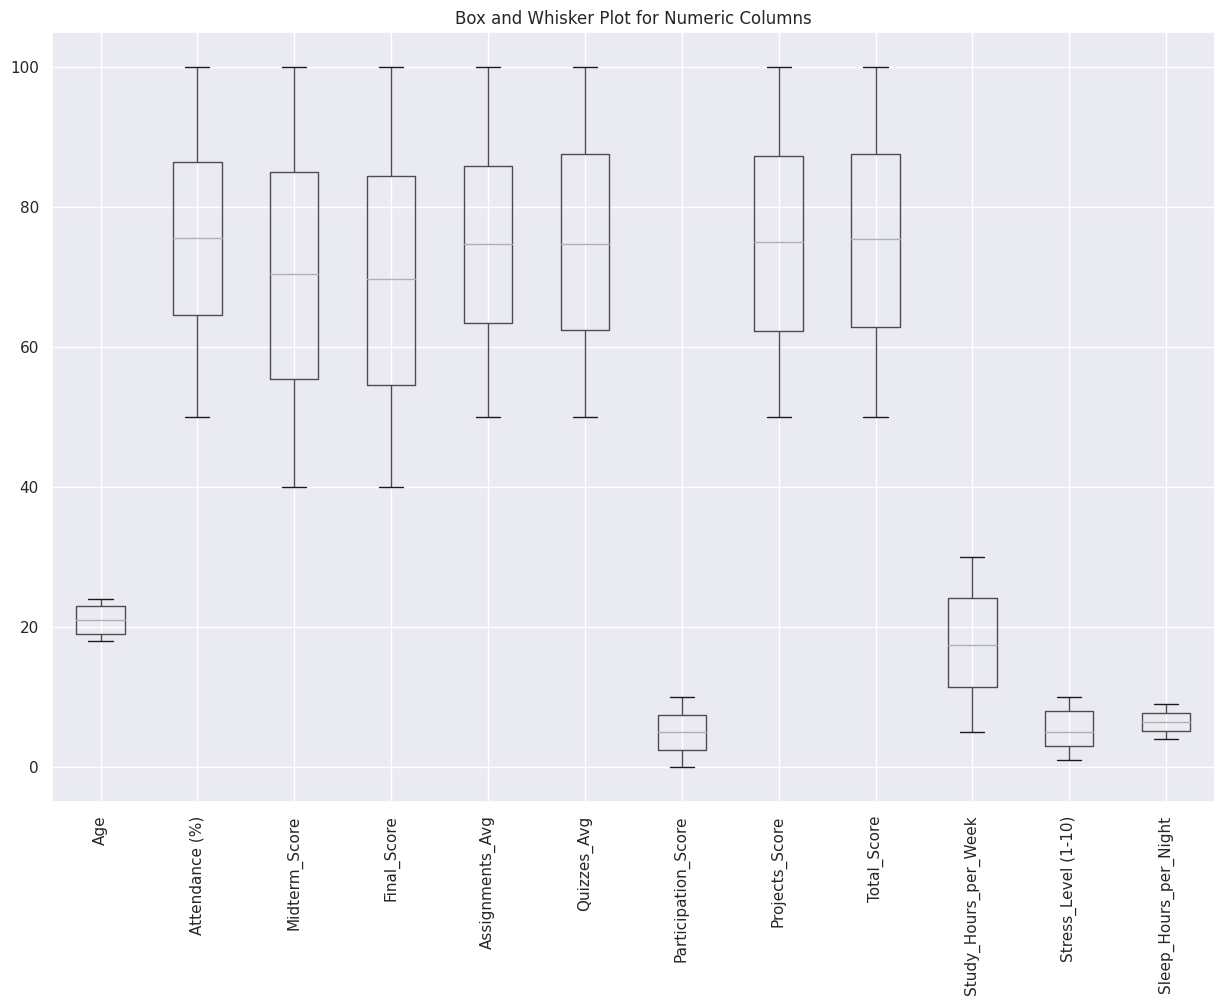

In [34]:
# Create a box and whisker plot for numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns].boxplot(rot=90, figsize=(15, 10))
plt.title('Box and Whisker Plot for Numeric Columns')
plt.show()

Sometimes with a box and whiskers there can be gaps in the data that goes unseen.  Let's look at some jitter strips as well.

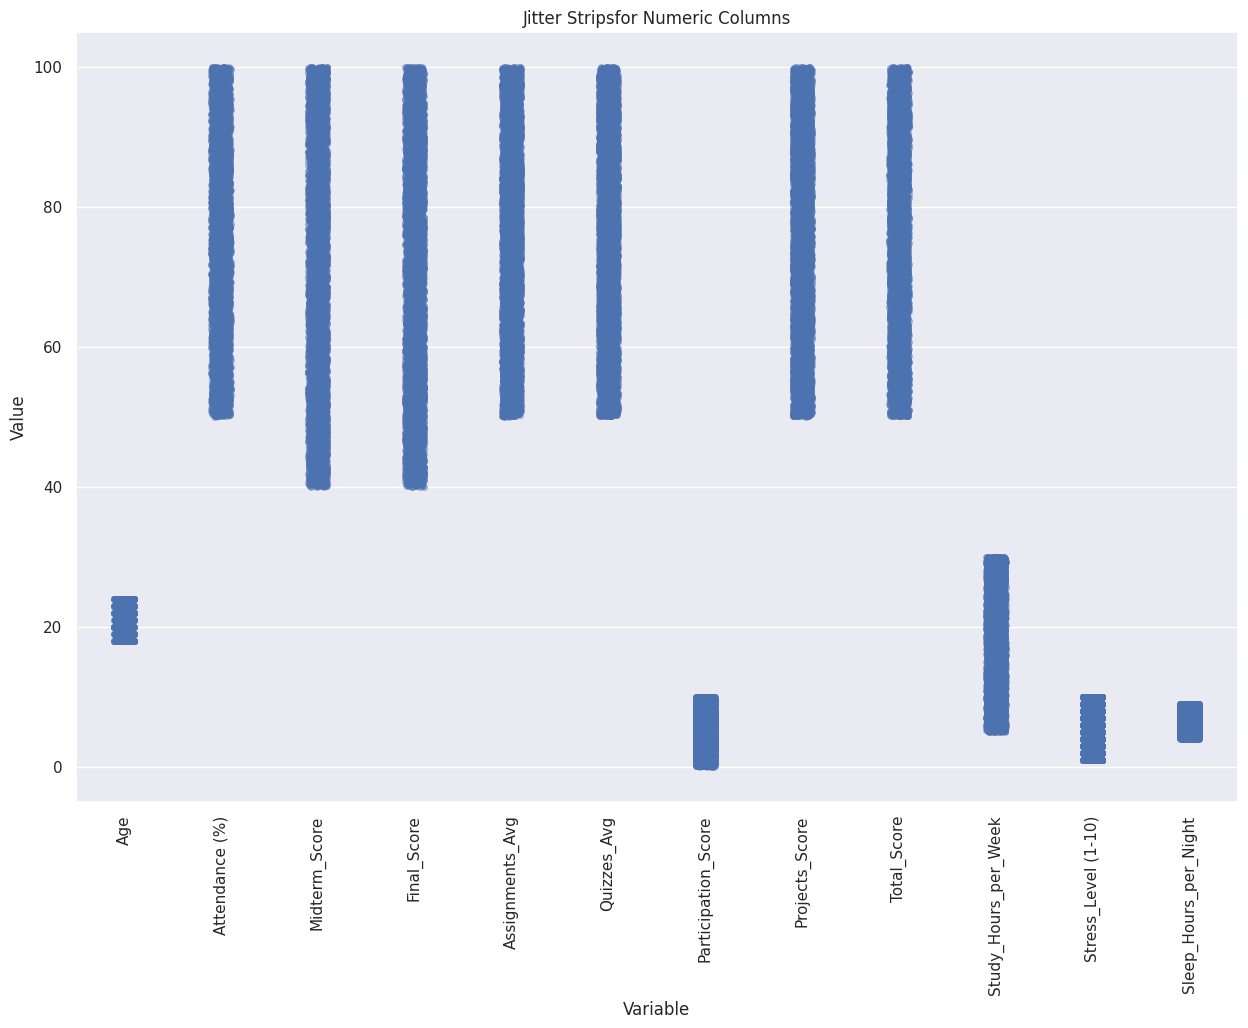

In [35]:
# Melt the dataframe to long format
df_melted = df.melt(id_vars='Grade', value_vars=numeric_columns, var_name='Variable', value_name='Value')

# Create a strip plot for all numeric columns
plt.figure(figsize=(15, 10))
sns.stripplot(x='Variable', y='Value', data=df_melted, jitter=True, alpha=0.5)
plt.title('Jitter Stripsfor Numeric Columns')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.show()

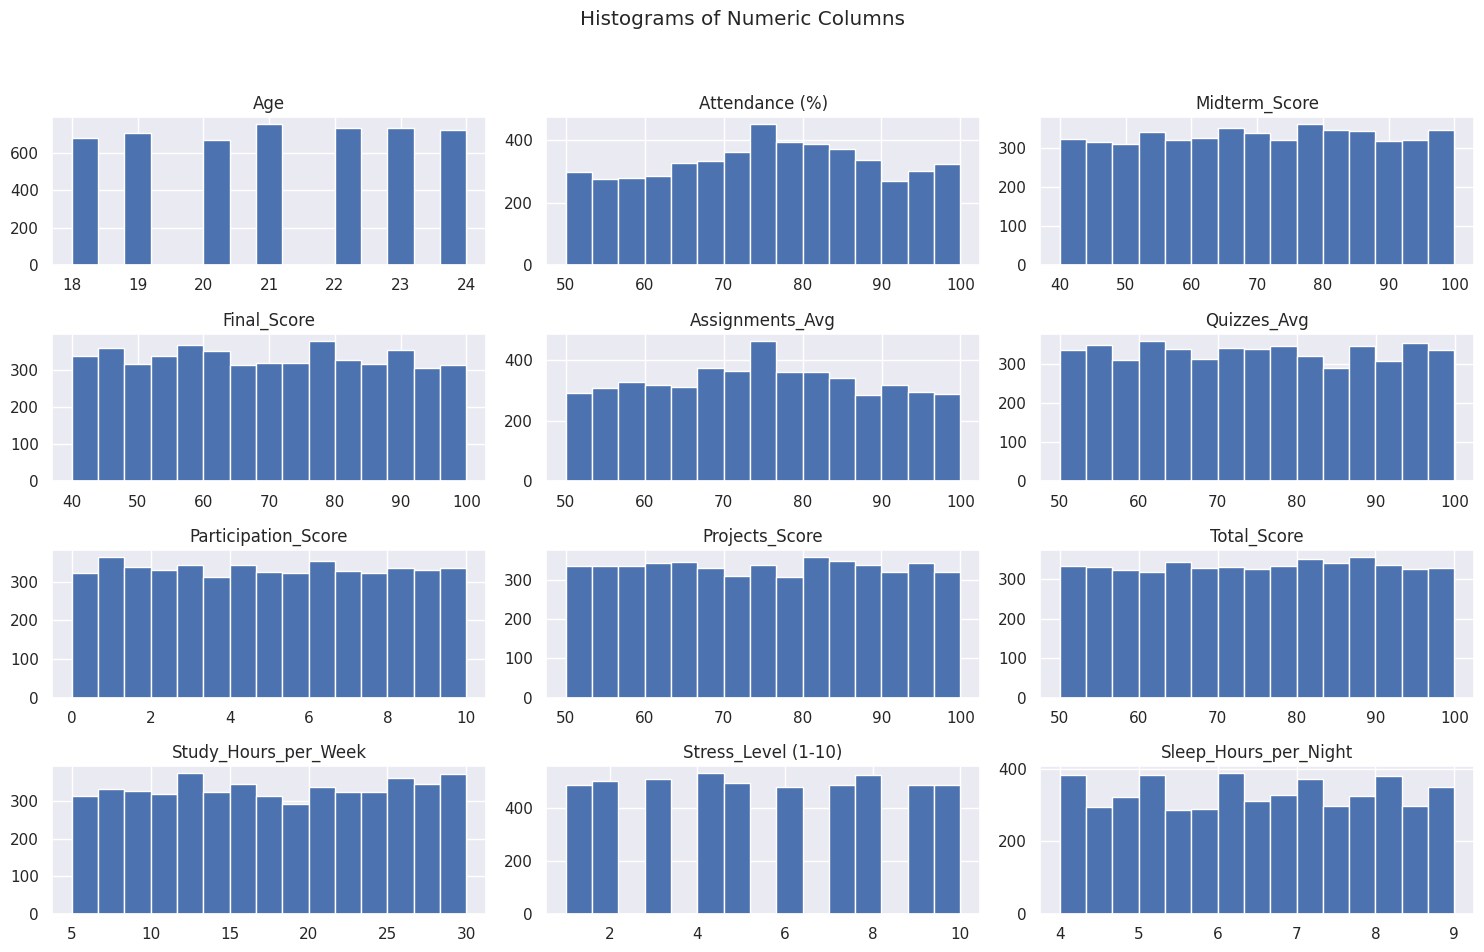

In [36]:
# Create histograms for all numeric columns
df[numeric_columns].hist(bins=15, figsize=(15, 10), layout=(4, 3))
plt.suptitle('Histograms of Numeric Columns')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()

# Asking some questions with the visualizations

I could use a box and whisker plot here; however, I like jitter strips  as they give a better sense of the distribution of the data.  

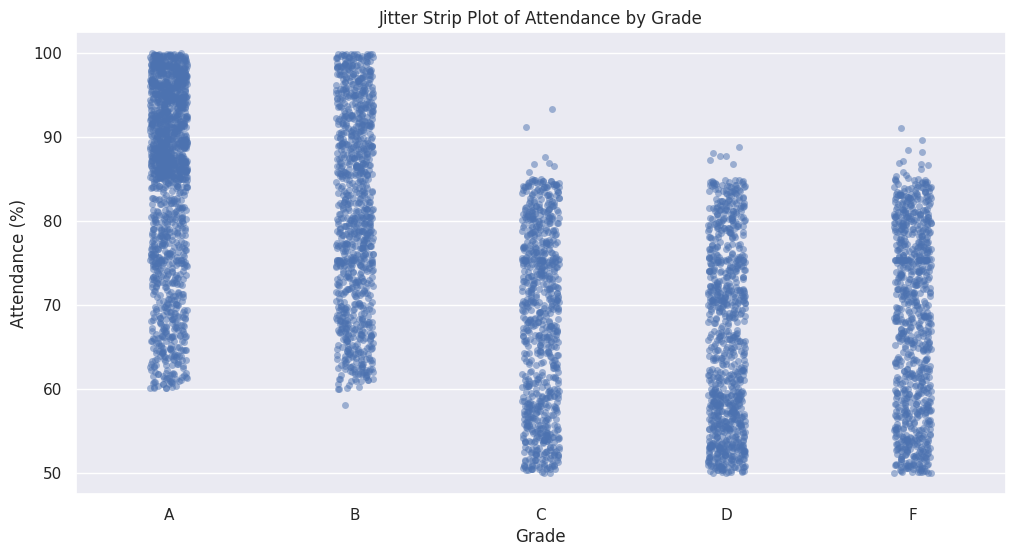

In [37]:
# Create a jitter strip plot of attendance by grade
df['Grade'] = pd.Categorical(df['Grade'], categories=sorted(df['Grade'].unique()), ordered=True)
sns.stripplot(x='Grade', y='Attendance (%)', data=df, jitter=True, alpha=0.5)
plt.title('Jitter Strip Plot of Attendance by Grade')
plt.xlabel('Grade')
plt.ylabel('Attendance (%)')
plt.show()

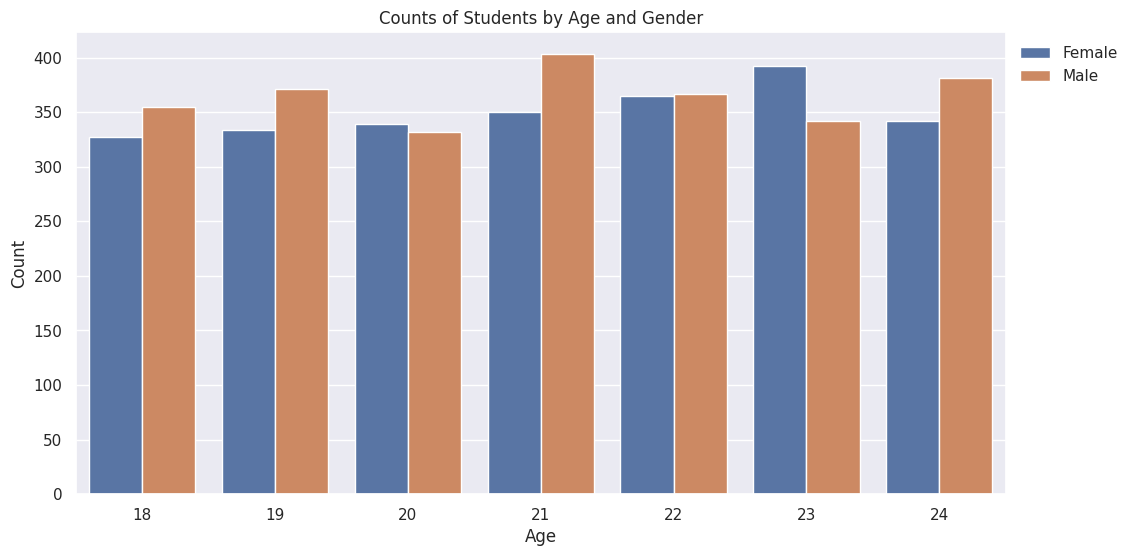

In [38]:
# Create a bar chart of the counts of students by age and gender
sns.countplot(x='Age', hue='Gender', data=df)
plt.title('Counts of Students by Age and Gender')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Statistics

We'll start with Chi-Squared for the nominal Categorical Data.

In [39]:
from itertools import combinations
from scipy.stats import chi2_contingency

# List of categorical columns
categorical_columns = ['Gender', 'Department', 'Parent_Education_Level', 'Internet_Access_at_Home', 'Extracurricular_Activities', 'Family_Income_Level']

# Create a function to perform chi-square test and print results
def chi_square_test(contingency_table, var1, var2):
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    print(f"Chi-Square Test for {var1} and {var2}:")
    print(f"Chi2: {chi2}, p-value: {p}, Degrees of Freedom: {dof}")
    print(f"\nContingency Table for {var1} and {var2}:")
    print(contingency_table)
    print("\n")

# Perform chi-square test for each pair of categorical variables
for var1, var2 in combinations(categorical_columns, 2):
    contingency_table = pd.crosstab(df[var1], df[var2])
    chi_square_test(contingency_table, var1, var2)

    # Create a summary table
    summary_table = []

    # Perform chi-square test for each pair of categorical variables and store the results
    for var1, var2 in combinations(categorical_columns, 2):
        contingency_table = pd.crosstab(df[var1], df[var2])
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        summary_table.append([var1, var2, chi2, p])

    # Convert the summary table to a DataFrame
    summary_df = pd.DataFrame(summary_table, columns=['Variable 1', 'Variable 2', 'Chi2', 'p-value'])

    # Print the summary table
    print(summary_df)

Chi-Square Test for Gender and Department:
Chi2: 1.0821761661104312, p-value: 0.7813784767159299, Degrees of Freedom: 3

Contingency Table for Gender and Department:
Department  Business    CS  Engineering  Mathematics
Gender                                              
Female           490  1005          705          249
Male             516  1017          764          254


                    Variable 1                  Variable 2       Chi2  \
0                       Gender                  Department   1.082176   
1                       Gender      Parent_Education_Level   0.716400   
2                       Gender     Internet_Access_at_Home   0.195200   
3                       Gender  Extracurricular_Activities   0.352391   
4                       Gender         Family_Income_Level   5.289493   
5                   Department      Parent_Education_Level   7.309668   
6                   Department     Internet_Access_at_Home   0.942077   
7                   Department  Extr

# Preparing to model the data
## Transforming the data

## Encoding the data

In [63]:
# One-hot encode the categorical columns including 'Grade' and drop one of each to avoid the dummy variable trap
df_encoded = pd.get_dummies(df, columns=categorical_columns + ['Grade'], drop_first=True)

# Rename the column to make life better
df_encoded.rename(columns={"Parent_Education_Level_Master's": "Parent_Education_Level_Masters"}, inplace=True)
df_encoded.rename(columns={"Attendance (%)": "Attendance"}, inplace=True)
df_encoded.rename(columns={"Stress_Level (1-10)": "Stress_Level"}, inplace=True)
df_encoded.rename(columns={"Parent_Education_Level_High School": "Parent_Education_Level_High_School"}, inplace=True)

# Display the first few rows of the encoded dataframe
df_encoded.head()


,Age,Attendance,Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Total_Score,Study_Hours_per_Week,...,Parent_Education_Level_Missing,Parent_Education_Level_PhD,Internet_Access_at_Home_Yes,Extracurricular_Activities_Yes,Family_Income_Level_Low,Family_Income_Level_Medium,Grade_B,Grade_C,Grade_D,Grade_F
0,22,52.29,55.03,57.82,84.220,74.06,3.99,85.90,56.09,6.2,...,False,False,True,False,False,True,False,False,False,True
1,18,97.27,97.23,45.80,70.096,94.24,8.32,55.65,50.64,19.0,...,True,False,True,False,False,True,False,False,False,False
2,24,57.19,67.05,93.68,67.700,85.70,5.05,73.79,70.30,20.7,...,False,False,True,False,True,False,False,False,True,False
3,24,95.15,47.79,80.63,66.060,93.51,6.54,92.12,61.63,24.8,...,False,False,True,True,False,False,False,False,False,False
4,23,54.18,46.59,78.89,96.850,83.70,5.97,68.42,66.13,15.4,...,False,False,True,True,False,False,False,False,False,True


Mean Squared Error: 219.12964191817252
R-squared: -0.009517106953290888


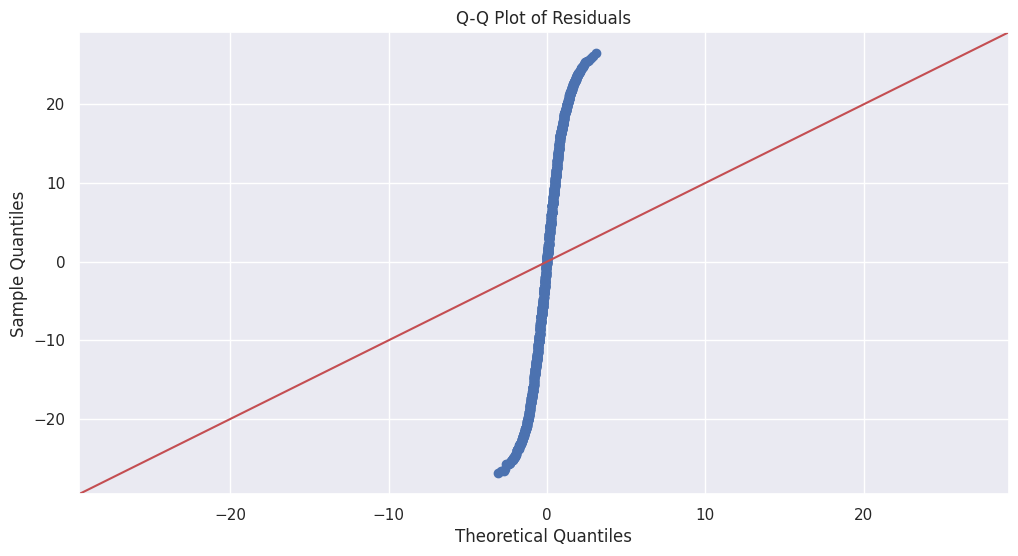

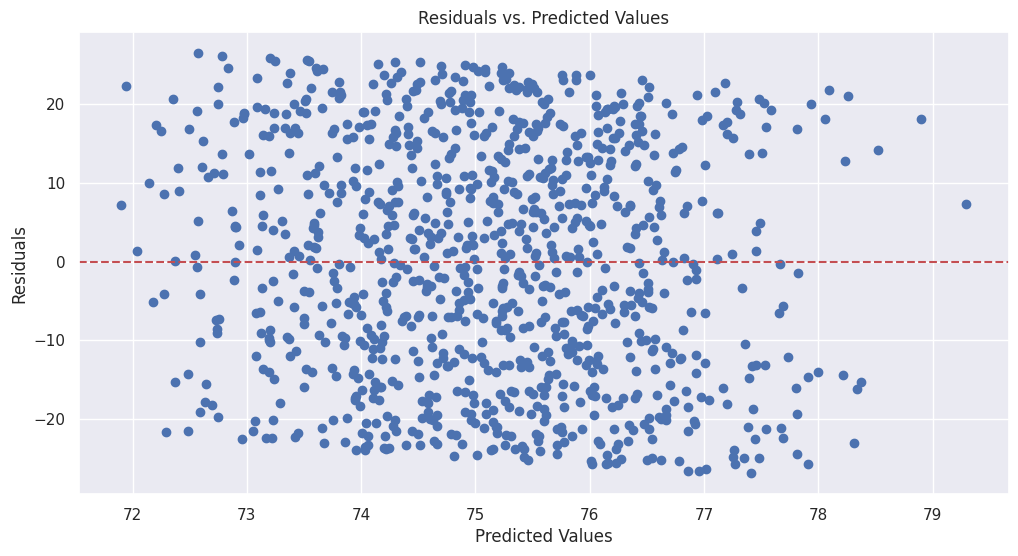

Durbin-Watson statistic: 2.0574531637351523


In [61]:


# Define the features (independent variables) and the target (dependent variable)
X = df_encoded.drop(columns=['Total_Score'])
y = df_encoded['Total_Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model using the training set
model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Calculate residuals
residuals = y_test - y_pred

# Check for normality of residuals using Q-Q plot
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Check for homoscedasticity using a scatter plot of residuals vs. predicted values
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Check for independence of residuals using the Durbin-Watson test
dw_stat = sm.stats.durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_stat}')

In [64]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Define the formula for the ANOVA model
formula = (
    'Total_Score ~ Gender_Male + Department_CS + Department_Engineering + '
    'Department_Mathematics + Parent_Education_Level_High_School + '
    'Parent_Education_Level_Masters + Parent_Education_Level_Missing + '
    'Parent_Education_Level_PhD + Internet_Access_at_Home_Yes + '
    'Extracurricular_Activities_Yes + Family_Income_Level_Low + '
    'Family_Income_Level_Medium + Grade_B + Grade_C + Grade_D + '
    'Grade_F + Age + Attendance + Midterm_Score + Final_Score + '
    'Assignments_Avg + Quizzes_Avg + Participation_Score + Projects_Score + '
    'Study_Hours_per_Week + Stress_Level + Sleep_Hours_per_Night'
)

# Fit the ANOVA model
model = ols(formula, data=df_encoded).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA table
print(anova_table)

                                          sum_sq      df         F    PR(>F)
Gender_Male                         1.044962e+02     1.0  0.504307  0.477647
Department_CS                       6.150363e+02     1.0  2.968216  0.084978
Department_Engineering              2.119271e+02     1.0  1.022778  0.311910
Department_Mathematics              4.097363e+02     1.0  1.977421  0.159725
Parent_Education_Level_High_School  5.838371e+01     1.0  0.281765  0.595571
Parent_Education_Level_Masters      1.670931e+02     1.0  0.806405  0.369229
Parent_Education_Level_Missing      2.359522e+01     1.0  0.113872  0.735792
Parent_Education_Level_PhD          4.083809e-01     1.0  0.001971  0.964592
Internet_Access_at_Home_Yes         2.237865e+02     1.0  1.080012  0.298745
Extracurricular_Activities_Yes      2.978972e+01     1.0  0.143768  0.704580
Family_Income_Level_Low             9.537210e+02     1.0  4.602736  0.031969
Family_Income_Level_Medium          4.970575e+02     1.0  2.398841  0.121489